# 随机森林回归

In [1]:
from sklearn.ensemble import RandomForestRegressor

## 核心参数

class RandomForestRegressor(ForestRegressor)
 |  RandomForestRegressor(n_estimators=100, *, criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=1.0, max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)
 
 
- n_estimators=100: 随机森林中树都个数
- criterion='squared_error': 用于衡量分裂质量的函数,{"friedman_mse", "absolute_error","poisson"}
-  max_depth=None,树都最大深度
- min_samples_split: 分裂节点所需要的最小样本数
- min_samples_leaf: 叶子节点所需的最小样本数
- min_weight_fraction_leaf: 叶子节点所需要的最小权重分数
- max_features=1.0, 寻找最佳分裂时,考虑的特征数量: {sqrt， log2}
- min_impurity_decrease=0.0, 如果这个分裂导致的不纯的度减少大于或等于这个值,则节点就会分裂
- bootstrap=True, 是否使用自助样本构建
- oob_score=False, 是否使用袋外数据
- n_jobs=None, 并行工作的数量,根据你自己电脑的CPU内核数来决定
- random_state: 用于构建树都样本的随机性,以及寻找最佳的分裂特征时考虑的随机性
-  verbose=0: 控制台拟合和预测的详细程度
- ccp_alpha=0.0, 用于空值最小成本复杂性剪枝的参数
- max_samples=None, 如果这里boostrap设定为True, 他就是从X中抽取用于训练每个基学习器的样本数量

## 随机森林回归案例1-缺失值处理

In [4]:
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestRegressor

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
print('Python version:', sys.version)
print('Pandas version:', pd.__version__)
print('Numpy version:', np.__version__)
print('Matplotlib version:', matplotlib.__version__)

Python version: 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]
Pandas version: 2.2.2
Numpy version: 1.26.4
Matplotlib version: 3.8.4


In [5]:
raw_df = pd.read_csv('./data/boston.txt', sep=r"\s+",skiprows=22, header=None)

In [9]:
raw_df.values[::2,:]
raw_df.values[1::2,2]
data = np.hstack([raw_df.values[::2,:], raw_df.values[1::2,:2]])
target = raw_df.values[1::2,2]

In [15]:
print(f"数据集的大小为:{data.shape}")
print(f"数据集的标签的大小为: {target.shape}")

数据集的大小为:(506, 13)
数据集的标签的大小为: (506,)


In [39]:
X_full, y_full = data, target
n_samples = X_full.shape[0]
n_features = X_full.shape[1]

# 创建一个随机数生成器, 并设置种子是1210,以确保结果都可重复性
rng = np.random.RandomState(1210)
# 缺失值比例是0.5, 
missing_rate = 0.5 # 设置缺失的比例是0.5
# 计算需要生成的缺失数据的总数,
n_missing_samples = int(np.floor(n_samples * n_features * missing_rate))
# 希望是创建一个数字,包含在0-506的中间的行索引,和0-13之间的列索引,
# 生成确实特征的索引,随机的生成n_missing_samples个不同的索引
missing_feautres = rng.randint(0, n_features, n_missing_samples)
# 生成缺失样本的索引,随机选择n_missing_samples个不同的索引
missing_samples = rng.randint(0, n_samples, n_missing_samples)
X_missing = X_full.copy()
y_missing = y_full.copy()
X_missing[missing_samples, missing_feautres] = np.nan
X_missing = pd.DataFrame(X_missing)

### 缺失值的处理

In [35]:
from sklearn.impute import SimpleImputer
# 使用均值这种填充从恶略
impmean =  SimpleImputer(missing_values=np.nan, strategy='mean')
X_missing_mean = impmean.fit_transform(X_missing)

In [40]:
# 使用常数0这种填充策略
imp_0 = SimpleImputer(missing_values=np.nan, strategy="constant",fill_value=0)
X_missing_zero = imp_0.fit_transform(X_missing)

### 随机森林填补缺失值

特征T不缺失的值对应其他n-1个特征 + 原本的标签: X_train
特征T不缺失的值: Y_train
特征T缺失的值对应其他n-1个特征 + 本来都 标签: X_test
特征T缺失的值: Y_test 

In [45]:
X_missing_reg = X_missing.copy() # 创建一个副本,

# 对每列的缺失值做排序,并获得排序之后的索引
sortindex = np.argsort(X_missing_reg.isnull().sum(axis=0)).values 
for  i in sortindex:
    df = X_missing_reg
    fillc = df.iloc[:, i] # 获取当前列的特征
    df = pd.concat([df.loc[:, df.columns != i], pd.DataFrame(y_full)], axis=1)
    
    # 对于这些新的特征,含有缺失值的列使用0进行填补操作
    df_0 = SimpleImputer(missing_values=np.nan, \
                         strategy='constant', fill_value=0).fit_transform(df)
    
    Ytrain = fillc[fillc.notnull()] # 获取当前列中非缺失的值当做训练标签
    Ytest = fillc[fillc.isnull()] # 获取当前列中的缺失值作为测试标签
    Xtrain = df_0[Ytrain.index, :] # 获取对应非缺失标签的特征数据作为训练集
    Xtest = df_0[Ytest.index, :] #获取对应缺失标签的特征数据作为测试集
    
    # 使用随机森林来进行缺失值的填补
    rfg = RandomForestRegressor(n_estimators=100)
    rfg.fit(Xtrain, Ytrain)
    ypredict = rfg.predict(Xtest)
    X_missing_reg.loc[X_missing_reg.iloc[:,i].isnull(), i] = ypredict

## 对填补好的缺失值进行建模

In [48]:
X = [X_full, X_missing_mean, X_missing_zero, X_missing_reg]
mse = []
std = []
for x in X:
    estimator = RandomForestRegressor(n_estimators=100, random_state=1210)
    score = cross_val_score(estimator, x, y_full, scoring='neg_mean_squared_error',cv=5).mean()
    mse.append(score * -1)
    print(f"均方误差为: {-np.mean(score)}")
    print(f"R^2为: {-np.mean(score_r2)}")

### 可视化结果

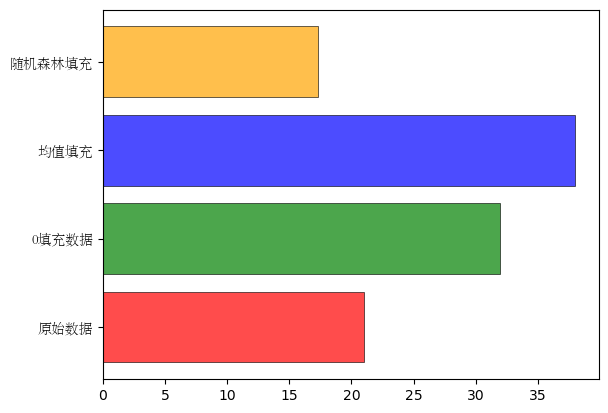

In [57]:
x_label = ['原始数据', '0填充数据','均值填充','随机森林填充']
colors = ['r','g','b','orange']

ax = plt.subplot(111)

for i in np.arange(len(mse)):
    ax.barh(i, mse[i], color=colors[i],alpha=.7,edgecolor='black',linewidth=.6, align='center')
ax.set_yticks(np.arange(len(mse)))
ax.set_yticklabels(x_label, fontproperties='STsong')
plt.show()

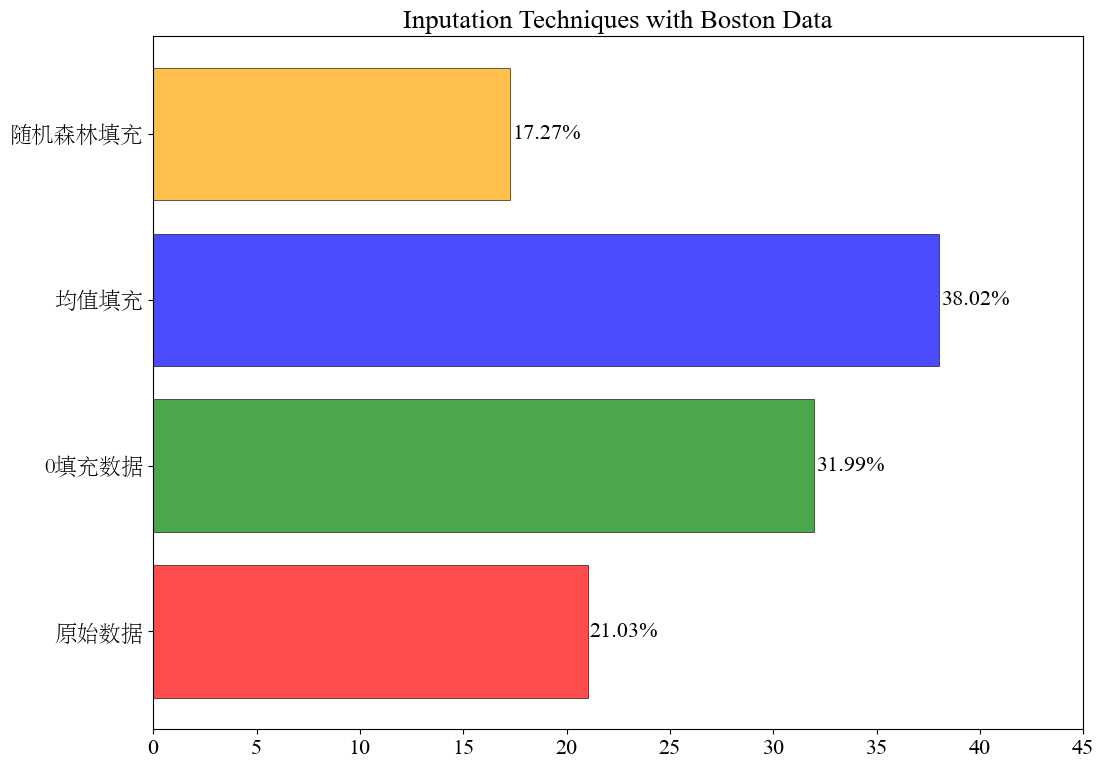

In [84]:
plt.rcParams['font.sans-serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.figure(figsize=(12,9),dpi=100)
plt.barh(range(4),mse,alpha=.7,edgecolor='black',linewidth=.6,color=['r','g','b','orange'])

for  x,y in zip(range(4),mse):
    plt.text(y+.1, x, f"{y:.2f}%", ha='left',va='center')


plt.yticks(range(4), x_label,fontproperties='STsong',fontsize=16)
plt.xlim(0,45)
plt.title("Inputation Techniques with Boston Data")
plt.show()